In [88]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px





# Lade das Datenset
charging_set = pd.read_csv("data/cleaned_charging_set.csv")
charging_set.head(3)



,id,kWhDelivered,siteID,spaceID,stationID,timezone,userID,connectionTime_date,connectionTime_time,disconnectTime_date,...,paymentRequired,requestedDeparture,UserID,WhPerMile_present,kWhRequested_present,milesRequested_present,minutesAvailable_present,modifiedAt_present,paymentRequired_present,requestedDeparture_present
0,5e23b149f9af8b5fe4b973cf,25.016,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,2020-01-02,13:08:54,2020-01-02,...,True,"Thu, 02 Jan 2020 20:51:54 GMT",1,1,1,1,1,1,1,1
1,5e23b149f9af8b5fe4b973d0,33.097,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,2020-01-02,13:36:50,2020-01-02,...,True,"Thu, 02 Jan 2020 23:31:50 GMT",1,1,1,1,1,1,1,1
2,5e23b149f9af8b5fe4b973d1,6.521,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,2020-01-02,13:56:35,2020-01-03,...,True,"Thu, 02 Jan 2020 14:56:35 GMT",1,1,1,1,1,1,1,1


In [89]:
print(charging_set.columns)
# Anzahl der Lade-Events pro Tag berechnen
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour


events_at_day = charging_set.groupby('hour').size().reset_index(name='count')

# Count all loading-events over the available timeframe, ploted on hours of the day
fig = px.bar(
    events_at_day,
    x='hour',
    y='count',
    title='Loading-events over the day (siteID = all)',
    labels={'hour': 'Hour', 'count': 'Number of loading-events'}
)

# Layout adjustment
fig.update_traces(marker_color='#00008B')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white"
)

# Show grafic
fig.show()


for site_id in [1, 2]:
    site_data = charging_set[charging_set['siteID'] == site_id]
    site_events_at_day = site_data.groupby('hour').size().reset_index(name='count')

    # Interactive visualization
    fig = px.bar(
        site_events_at_day,
        x='hour',
        y='count',
        title=f'Loading-events over the day (siteID = {site_id})',
        labels={'hour': 'Hour', 'count': 'Number of loading-events'},
    )

    fig.update_traces(marker_color='#1f77b4')

# Layout adjustment
    fig.update_layout(
        title_font_size=18,
        legend_title_text="Legend",
        template="plotly_white"
    )

    # Show grafic
    fig.show()

Index(['id', 'kWhDelivered', 'siteID', 'spaceID', 'stationID', 'timezone',
       'userID', 'connectionTime_date', 'connectionTime_time',
       'disconnectTime_date', 'disconnectTime_time', 'doneChargingTime_date',
       'doneChargingTime_time', 'connectionTime_year', 'connectionTime_month',
       'connectionTime_day', 'disconnectTime_year', 'disconnectTime_month',
       'disconnectTime_day', 'doneChargingTime_year', 'doneChargingTime_month',
       'doneChargingTime_day', 'chargingDuration', 'WhPerMile', 'kWhRequested',
       'milesRequested', 'minutesAvailable', 'modifiedAt', 'paymentRequired',
       'requestedDeparture', 'UserID', 'WhPerMile_present',
       'kWhRequested_present', 'milesRequested_present',
       'minutesAvailable_present', 'modifiedAt_present',
       'paymentRequired_present', 'requestedDeparture_present'],
      dtype='object')


In [90]:
# Aggregation on months
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

events_per_month = charging_set.groupby('connectionTime_month').size().reset_index(name='count')

# Add month names
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)

# Count all loading-events over the available timeframe, ploted on hours of the day
fig = px.bar(
    events_per_month,
    x='month_name',
    y='count',
    title='Loading-events per month',
    labels={'hour': 'Month', 'count': 'Number of loading-events'}
)

# Layout adjustment
fig.update_traces(marker_color='#FF8C00')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white"
)

# Show grafic
fig.show()



In [91]:
# Anzahl der Lade-Events pro Tag berechnen
events_per_day = charging_set.groupby('connectionTime_date').size().reset_index(name='count')

 # Interaktive Visualisierung
fig = px.bar(
    events_per_day,
    x='connectionTime_date',
    y='count',
    title='Lade-Events über die Zeit',
    labels={'connectionTime_date': 'Datum', 'count': 'Anzahl der Lade-Events'}
)

# Einheitliche Farbe für die Balken
fig.update_traces(marker_color='#00008B')  # Blau als einheitliche Farbe

# Layout-Anpassungen für bessere Darstellung
fig.update_layout(
    xaxis_title="Datum",
    yaxis_title="Anzahl der Lade-Events",
    title_font_size=18,
    legend_title_text=None,  # Keine Legende nötig
    template="plotly_white"
)

# Grafik anzeigen
fig.show()



In [92]:
events_per_year = charging_set.groupby('connectionTime_year').size().reset_index(name='count')


# Count all loading-events over the available timeframe, ploted per year
fig = px.bar(
    events_per_year,
    x='connectionTime_year',
    y='count',
    title='Loading-events per year (siteID = all)',
    labels={'hour': 'connectionTime_year', 'count': 'Number of loading-events'}
)

# Layout adjustment
fig.update_traces(marker_color='#00008B')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white",
     xaxis=dict(
        tickmode='array',  # Specify ticks explicitly
        tickvals=events_per_year['connectionTime_year'].unique(),  # Use unique years as tick values
        title="Year"
    )
)

# Show grafic
fig.show()




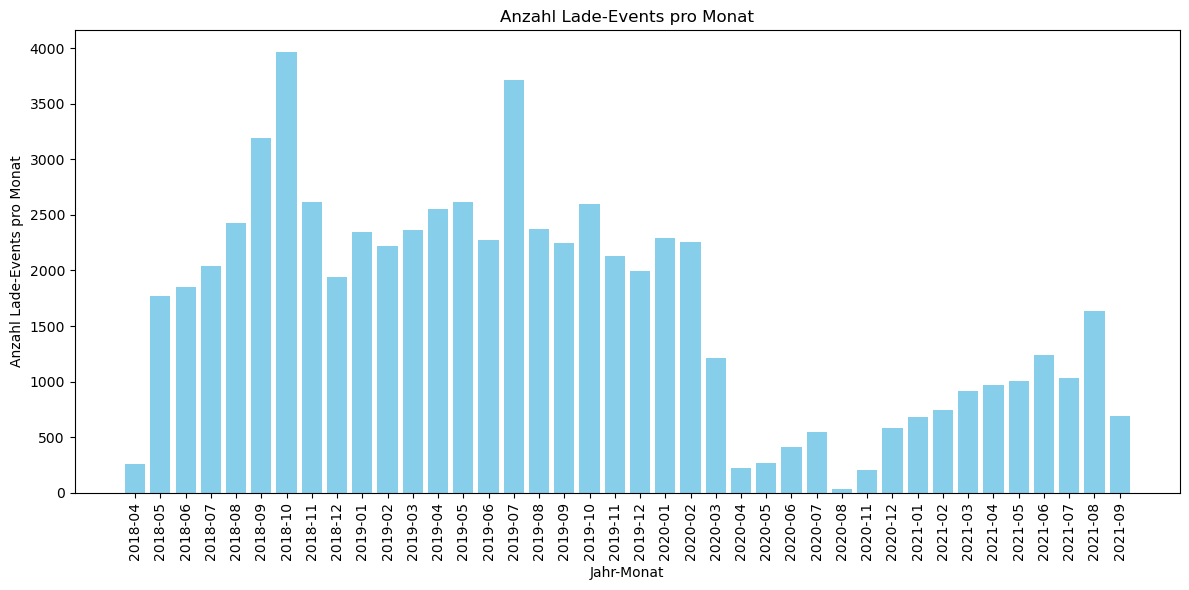

In [93]:
charging_set['connectionTime_date'] = pd.to_datetime(charging_set['connectionTime_date'])

# Jahr und Monat extrahieren
charging_set['year'] = charging_set['connectionTime_date'].dt.year
charging_set['month'] = charging_set['connectionTime_date'].dt.month

# Berechnung der durchschnittlichen Temperatur pro Jahr und Monat
avg_temperatures = charging_set.groupby(['year', 'month']).size().reset_index(name='count')

# Erstellen des Balkendiagramms
plt.figure(figsize=(12, 6))
# Kombiniere Jahr und Monat für die X-Achse, z.B. '2022-01' für Januar 2022
avg_temperatures['year_month'] = avg_temperatures['year'].astype(str) + '-' + avg_temperatures['month'].astype(str).str.zfill(2)

# Erstellen des Balkendiagramms
plt.bar(avg_temperatures['year_month'], avg_temperatures['count'], color='skyblue')

# Titel und Beschriftungen
plt.title('Anzahl Lade-Events pro Monat')
plt.xlabel('Jahr-Monat')
plt.ylabel('Anzahl Lade-Events pro Monat')

# Optional: X-Achse formatieren (dreh die Labels, damit sie lesbar sind)
plt.xticks(rotation=90)

# Layout optimieren
plt.tight_layout()

# Diagramm anzeigen
plt.show()